In [93]:
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter

%matplotlib inline

### https://www.baseball-reference.com/

tb --> Team Finder, Game, Batting --> Sort by 'Date of Game': 
https://www.baseball-reference.com/play-index/game_finder.cgi?class=team&type=b

tp --> Team Finder, Game, Pitching --> Sort by 'Date of Game':
https://www.baseball-reference.com/play-index/game_finder.cgi?class=team&type=p

pp --> Player Finder, Game, Pitching --> Sort by 'Date of Game', STARTING PITCHERS ONLY:
https://www.baseball-reference.com/play-index/game_finder.cgi?type=p

To do:
- Assign Stadium, and possibly One-hot Encode
- Include ADI metrics

In [216]:
# 2017 through 2018

In [225]:
# Read in the data
tb_away = pd.read_csv('../data/team_batting_away_2018-05-14.csv')
tb_home = pd.read_csv('../data/team_batting_home_2018-05-14.csv')

tp_away = pd.read_csv('../data/team_pitching_away_2018-05-14.csv')
tp_home = pd.read_csv('../data/team_pitching_home_2018-05-14.csv')

pp_L = pd.read_csv('../data/player_pitching_L_2018-05-14.csv') # Starting Pitchers only
pp_R = pd.read_csv('../data/player_pitching_R_2018-05-14.csv') # Starting Pitchers only

In [218]:
print(tb_away.shape)
print(tb_home.shape)

print(tp_away.shape)
print(tp_home.shape)

print(pp_L.shape)
print(pp_R.shape)

(2909, 35)
(2909, 35)
(2909, 43)
(2909, 43)
(1573, 45)
(4245, 45)


In [219]:
# Make sure min/max dates match
print(tb_away['Date'].min())
print(tb_home['Date'].min())
print(tp_away['Date'].min())
print(tp_home['Date'].min())
print(pp_L['Date'].min())
print(pp_R['Date'].min())

print('\n')

print(tb_away['Date'].max())
print(tb_home['Date'].max())
print(tp_away['Date'].max())
print(tp_home['Date'].max())
print(pp_L['Date'].max())
print(pp_R['Date'].max())

2017-04-02
2017-04-02
2017-04-02
2017-04-02
2017-04-02
2017-04-02


2018-05-14
2018-05-14
2018-05-14
2018-05-14
2018-05-14
2018-05-14


In [226]:
# One-hot encode features
tb_away['Home?'] = 0
tb_home['Home?'] = 1

tp_away['Home?'] = 0
tp_home['Home?'] = 1

pp_L['RH?'] = 0
pp_R['RH?'] = 1

In [229]:
# Collapse into combined dataframes
tb = pd.concat([tb_away, tb_home])
tp = pd.concat([tp_away, tp_home])
pp = pd.concat([pp_L, pp_R])

In [236]:
tb.reset_index(drop=True, inplace=True)
tp.reset_index(drop=True, inplace=True)
pp.reset_index(drop=True, inplace=True)

In [230]:
# Define home stadiums, so we can define what stadium was played in
stadiums = {'BOS':'Fenway Park', 'CHC':'Wrigley Field', 'DET':'Comerica Park', 
            'LAA':'Angel Stadium', 'MIN':'Target Field', 'SDP':'Petco Park', 'SFG':'AT&T Park',
            'BAL':'Oriole Park', 'CLE':'Progressive Field', 'COL':'Coors Field', 
            'LAD':'Dodger Stadium', 'NYY': 'Yankee Stadium', 'PHI':'Citizens Bank Park',
            'PIT':'PNC Park', 'CHW':'Guaranteed Rate Field', 'CIN':'Great American Ball Park',
            'OAK':'O-A County Coliseum', 'TBR':'Tropicana Field', 'TEX':'Globe Life Park',
            'STL':'Busch Stadium', 'ATL':'SunTrust Park', 'KCR':'Kauffman Stadium', 
            'NYM':'Citi Field', 'WSN':'Nationals Park', 'MIA':'Marlins Park', 'MIL':'Miller Park',
            'ARI':'Chase Field', 'HOU':'Minute Maid Park', 'SEA':'Safeco Field', 
            'TOR':'Rogers Centre'
           }

In [240]:
# Assign stadium in 'tb', we will build up from there
stad_list = []
for i in tb.index:
    if tb.loc[i]['Home?'] == 1:
        stad_list.append(stadiums[tb.loc[i]['Tm']])
    else:
        stad_list.append(stadiums[tb.loc[i]['Opp']])
        
tb['Stad'] = stad_list

In [244]:
# Extract Doubleheader information from date, and make its own feature
tb['Game#'] = tb['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
tp['Game#'] = tp['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
pp['Game#'] = pp['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)

In [245]:
# Remove Doubleheader information from date
tb['Date'] = tb['Date'].apply(lambda x: x[:10])
tp['Date'] = tp['Date'].apply(lambda x: x[:10])
pp['Date'] = pp['Date'].apply(lambda x: x[:10])

In [246]:
# Make Date a datetime type
tb['Date'] = pd.to_datetime(tb['Date'])
tp['Date'] = pd.to_datetime(tp['Date'])
pp['Date'] = pd.to_datetime(pp['Date'])

In [247]:
# Sort team df's on Date, and then Team
tb.sort_values(['Date', 'Tm'], inplace=True)
tp.sort_values(['Date', 'Tm'], inplace=True)
pp.sort_values(['Date', 'Player'], inplace=True)

In [248]:
# Extract Win/Loss information from 'Rslt', and make its own feature
tb['Win/Loss'] = tb['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)
tp['Win/Loss'] = tp['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)
pp['Win/Loss'] = pp['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)

In [249]:
# Create Strikes-per-pitch, possible indicator of pitcher strength
tp['Str/Pit'] = tp['Str'] / tp['Pit']
pp['Str/Pit'] = pp['Str'] / pp['Pit']

In [250]:
# Create BattersFaced-per-inning-pitched, better pitches will face fewer batters
pp['BF/IP'] = pp['BF'] / pp['IP']

In [251]:
# Let's Drop the 2nd game of doubleheaders to simplify 
tb = tb[tb['Game#'].apply(lambda x: True if x==1 else False)]
tp = tp[tp['Game#'].apply(lambda x: True if x==1 else False)]
pp = pp[pp['Game#'].apply(lambda x: True if x==1 else False)]

In [252]:
print(tb.shape)
print(tp.shape)
print(pp.shape)

(5744, 39)
(5744, 47)
(5744, 50)


In [259]:
pp.isnull().sum()

Rk             0
Player         0
Date           0
Tm             0
Opp            0
Rslt           0
AppDec         0
IP             0
H              0
R              0
ER             0
BB             0
SO             0
HR             0
UER            0
Pit            1
Str            1
GSc            0
IR          5744
IS          5744
BF             0
AB             0
2B             0
3B             0
IBB            0
HBP            0
SH             0
SF             0
GDP            0
SB             0
CS             0
PO             0
BK             0
WP             0
ERA            0
WPA           10
RE24          10
aLI           10
DFS(DK)        8
DFS(FD)        8
Temp           0
WindDir      946
WindSpd        0
Prec        4040
Sky          786
RH?            0
Game#          0
Win/Loss       0
Str/Pit        1
BF/IP          0
dtype: int64

In [ ]:
# Note: A lot of missing "Precipitation" data

In [105]:
tb_window = ['PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', # batting strength
             'SO', 'GDP', 'LOB', # batting weakness
             'SB', # running strength
             'CS', # running weakness
             'Win/Loss', # overall team winningness
             'WPA', 'RE24', 'aLI' # BR Measures
            ]

tp_window = ['BF', 'R', 'H', '2B', '3B', 'ER', 'HR', 'Pit',# opponent pitching weakness
             'SO', 'WP', 'Str', 'GDP', 'Str/Pit', 'Win/Loss', # opponent pitching strength
             'WPA', 'RE24', 'aLI', # BR Measures
             '#' # May want to track average number of pitchers used
            ]

pp_window = ['IP', # May want to track deepness of starter
              'DFS(DK)', 'DFS(FD)', # May be rather informative
              'R', 'H', '2B', '3B', 'ER', 'HR', 'BB', 'BF/IP', 'WP', # opponent starting p weakness
              'SO', 'Str/Pit', 'GDP', # opponent starting p strength
              'GSc', 'WPA', 'RE24', 'aLI' # BR Measures
             ]

In [106]:
### DO I NEED TO SET DATE TO THE INDEX BEFORE ROLLING???

## Rolling Team Batting

In [107]:
teams = tb['Tm'].unique()

In [108]:
rolling_cols = []
for i in tb_window:
    rolling_cols.append('ewm10_'+i+'_tmbat')
for j in tb_window:
    rolling_cols.append('rm10_'+j+'_tmbat')
    
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [109]:
rolling_cols

['ewm10_PA_tmbat',
 'ewm10_R_tmbat',
 'ewm10_H_tmbat',
 'ewm10_2B_tmbat',
 'ewm10_3B_tmbat',
 'ewm10_HR_tmbat',
 'ewm10_RBI_tmbat',
 'ewm10_SO_tmbat',
 'ewm10_GDP_tmbat',
 'ewm10_LOB_tmbat',
 'ewm10_SB_tmbat',
 'ewm10_CS_tmbat',
 'ewm10_Win/Loss_tmbat',
 'ewm10_WPA_tmbat',
 'ewm10_RE24_tmbat',
 'ewm10_aLI_tmbat',
 'rm10_PA_tmbat',
 'rm10_R_tmbat',
 'rm10_H_tmbat',
 'rm10_2B_tmbat',
 'rm10_3B_tmbat',
 'rm10_HR_tmbat',
 'rm10_RBI_tmbat',
 'rm10_SO_tmbat',
 'rm10_GDP_tmbat',
 'rm10_LOB_tmbat',
 'rm10_SB_tmbat',
 'rm10_CS_tmbat',
 'rm10_Win/Loss_tmbat',
 'rm10_WPA_tmbat',
 'rm10_RE24_tmbat',
 'rm10_aLI_tmbat',
 'Tm',
 'Date']

In [110]:
tb_rolling = pd.DataFrame(columns = rolling_cols)

for team in teams:
    tb_team = tb[tb['Tm']==team]
    
    ewm10 = tb_team[tb_window].ewm(span=10, min_periods=1).mean().shift()
    rm10 = tb_team[tb_window].rolling(window=10, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm10, rm10], axis=1)

    this_df['Tm'] = team
    this_df['Date'] = tb_team['Date']
    this_df.columns = rolling_cols
    
    tb_rolling = pd.concat([tb_rolling, this_df])

In [111]:
tb_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)
tb.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [112]:
print(tb.shape)
print(tb_rolling.shape)

(1192, 32)
(1192, 34)


In [113]:
master = tb.merge(tb_rolling, how='left', on=['Date', 'Tm'])

In [114]:
master.shape

(1192, 64)

In [116]:
master[master['Tm']=='ARI'][['Date', 'H', 'rm10_H_tmbat']]

,Date,H,rm10_H_tmbat
0,2018-03-29,12,NaN
26,2018-03-30,8,12.000000
48,2018-03-31,5,10.000000
98,2018-04-02,14,8.333333
122,2018-04-03,8,9.750000
148,2018-04-04,7,9.400000
172,2018-04-05,9,9.000000
210,2018-04-07,5,9.000000
240,2018-04-08,7,8.500000
268,2018-04-09,5,8.333333


## Rolling Opposing Pitching Staff, Team Level

In [117]:
rolling_cols = []
for i in tp_window:
    rolling_cols.append('ewm10_'+i+'_opppit')
for j in tp_window:
    rolling_cols.append('rm10_'+j+'_opppit')
    
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [118]:
rolling_cols

['ewm10_BF_opppit',
 'ewm10_R_opppit',
 'ewm10_H_opppit',
 'ewm10_2B_opppit',
 'ewm10_3B_opppit',
 'ewm10_ER_opppit',
 'ewm10_HR_opppit',
 'ewm10_Pit_opppit',
 'ewm10_SO_opppit',
 'ewm10_WP_opppit',
 'ewm10_Str_opppit',
 'ewm10_GDP_opppit',
 'ewm10_Str/Pit_opppit',
 'ewm10_Win/Loss_opppit',
 'ewm10_WPA_opppit',
 'ewm10_RE24_opppit',
 'ewm10_aLI_opppit',
 'ewm10_#_opppit',
 'rm10_BF_opppit',
 'rm10_R_opppit',
 'rm10_H_opppit',
 'rm10_2B_opppit',
 'rm10_3B_opppit',
 'rm10_ER_opppit',
 'rm10_HR_opppit',
 'rm10_Pit_opppit',
 'rm10_SO_opppit',
 'rm10_WP_opppit',
 'rm10_Str_opppit',
 'rm10_GDP_opppit',
 'rm10_Str/Pit_opppit',
 'rm10_Win/Loss_opppit',
 'rm10_WPA_opppit',
 'rm10_RE24_opppit',
 'rm10_aLI_opppit',
 'rm10_#_opppit',
 'Tm',
 'Date']

In [119]:
tp_rolling = pd.DataFrame(columns = rolling_cols)

for team in teams:
    tp_team = tp[tp['Tm']==team]
    
    ewm10 = tp_team[tp_window].ewm(span=10, min_periods=1).mean().shift()
    rm10 = tp_team[tp_window].rolling(window=10, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm10, rm10], axis=1)

    this_df['Tm'] = team
    this_df['Date'] = tp_team['Date']
    this_df.columns = rolling_cols
    
    tp_rolling = pd.concat([tp_rolling, this_df])

In [120]:
tp_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [121]:
print(master.shape)
print(tp_rolling.shape)

(1192, 64)
(1192, 38)


In [122]:
master = master.merge(tp_rolling, how='left', left_on=['Date', 'Opp'], right_on=['Date', 'Tm'])

In [123]:
master.shape

(1192, 101)

In [124]:
master[master['Opp']=='ARI'][['Date', 'SO', 'rm10_SO_opppit']]

,Date,SO,rm10_SO_opppit
7,2018-03-29,12,NaN
31,2018-03-30,11,12.000000
56,2018-03-31,11,11.500000
111,2018-04-02,11,11.333333
133,2018-04-03,4,11.250000
156,2018-04-04,15,9.800000
190,2018-04-05,13,10.666667
235,2018-04-07,9,11.000000
263,2018-04-08,6,10.750000
286,2018-04-09,12,10.222222


## Rolling Opposing Starting Pitcher

In [126]:
rolling_cols = []
for i in pp_window:
    rolling_cols.append('ewm10_'+i+'_plpit')
for j in pp_window:
    rolling_cols.append('rm10_'+j+'_plpit')

rolling_cols.append('Player')
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [127]:
rolling_cols

['ewm10_IP_plpit',
 'ewm10_DFS(DK)_plpit',
 'ewm10_DFS(FD)_plpit',
 'ewm10_R_plpit',
 'ewm10_H_plpit',
 'ewm10_2B_plpit',
 'ewm10_3B_plpit',
 'ewm10_ER_plpit',
 'ewm10_HR_plpit',
 'ewm10_BB_plpit',
 'ewm10_BF/IP_plpit',
 'ewm10_WP_plpit',
 'ewm10_SO_plpit',
 'ewm10_Str/Pit_plpit',
 'ewm10_GDP_plpit',
 'ewm10_GSc_plpit',
 'ewm10_WPA_plpit',
 'ewm10_RE24_plpit',
 'ewm10_aLI_plpit',
 'rm10_IP_plpit',
 'rm10_DFS(DK)_plpit',
 'rm10_DFS(FD)_plpit',
 'rm10_R_plpit',
 'rm10_H_plpit',
 'rm10_2B_plpit',
 'rm10_3B_plpit',
 'rm10_ER_plpit',
 'rm10_HR_plpit',
 'rm10_BB_plpit',
 'rm10_BF/IP_plpit',
 'rm10_WP_plpit',
 'rm10_SO_plpit',
 'rm10_Str/Pit_plpit',
 'rm10_GDP_plpit',
 'rm10_GSc_plpit',
 'rm10_WPA_plpit',
 'rm10_RE24_plpit',
 'rm10_aLI_plpit',
 'Player',
 'Tm',
 'Date']

In [128]:
pitchers = pp['Player'].unique()

In [129]:
pp[pp['Player']==pitchers[0]]

,Rk,Player,Date,Tm,Opp,Rslt,AppDec,IP,H,R,...,ERA,WPA,RE24,aLI,DFS(DK),DFS(FD),Game#,Win/Loss,Str/Pit,BF/IP
1199,1182,Aaron Nola\nolaaa01,2018-03-29,PHI,ATL,L 5-8,GS-6,5.1,3,1,...,1.69,0.299,2.355,0.912,13.60,22.0,1,0,0.705882,3.921569
1049,1032,Aaron Nola\nolaaa01,2018-04-04,PHI,NYM,L 2-4,GS-5,5.0,4,2,...,3.60,0.063,0.506,0.857,9.85,21.0,1,0,0.632184,4.400000
901,884,Aaron Nola\nolaaa01,2018-04-10,PHI,CIN,W 6-1,GS-8 W,8.0,3,1,...,1.12,0.386,2.964,1.026,28.40,51.0,1,1,0.679612,3.625000
759,742,Aaron Nola\nolaaa01,2018-04-16,PHI,ATL,L 1-2,GS-6 L,6.0,4,2,...,3.00,0.070,1.040,1.028,10.50,18.0,1,0,0.623529,3.666667
629,612,Aaron Nola\nolaaa01,2018-04-21,PHI,PIT,W 6-2,GS-7 W,7.0,6,2,...,2.57,0.152,1.469,0.943,30.15,54.0,1,1,0.728155,3.714286
475,458,Aaron Nola\nolaaa01,2018-04-27,PHI,ATL,W 7-3,GS-7 W,7.0,7,3,...,3.86,0.162,0.469,1.164,16.95,36.0,1,1,0.683168,4.000000
330,313,Aaron Nola\nolaaa01,2018-05-02,PHI,MIA,W 6-0,GS-8 W,7.1,4,0,...,0.00,0.430,3.332,0.977,31.50,55.0,1,1,0.663366,3.521127
174,157,Aaron Nola\nolaaa01,2018-05-08,PHI,SFG,W 4-2,GS-7 W,7.0,5,1,...,1.29,0.268,2.469,0.952,38.75,66.0,1,1,0.688073,3.571429
36,19,Aaron Nola\nolaaa01,2018-05-13,PHI,NYM,W 4-2,GS-6 W,6.0,9,1,...,1.50,0.170,1.973,1.392,16.90,39.0,1,1,0.696629,4.166667


In [130]:
pp_rolling = pd.DataFrame(columns = rolling_cols)

for pitcher in pitchers:
    pp_pitcher = pp[pp['Player']==pitcher]
    
    ewm10 = pp_pitcher[pp_window].ewm(span=10, min_periods=1).mean().shift()
    rm10 = pp_pitcher[pp_window].rolling(window=10, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm10, rm10], axis=1)

    this_df['Player'] = pitcher
    this_df['Tm'] = pp_pitcher['Tm']
    this_df['Date'] = pp_pitcher['Date']
    this_df.columns = rolling_cols
    
    pp_rolling = pd.concat([pp_rolling, this_df])

In [131]:
pp_rolling.head()

,ewm10_IP_plpit,ewm10_DFS(DK)_plpit,ewm10_DFS(FD)_plpit,ewm10_R_plpit,ewm10_H_plpit,ewm10_2B_plpit,ewm10_3B_plpit,ewm10_ER_plpit,ewm10_HR_plpit,ewm10_BB_plpit,...,rm10_SO_plpit,rm10_Str/Pit_plpit,rm10_GDP_plpit,rm10_GSc_plpit,rm10_WPA_plpit,rm10_RE24_plpit,rm10_aLI_plpit,Player,Tm,Date
1199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola\nolaaa01,PHI,2018-03-29
1049,5.100000,13.600000,22.000000,1.000000,3.000000,1.000000,0.0,1.000000,0.000000,1.000000,...,3.000000,0.705882,0.000000,60.00,0.299000,2.355000,0.912000,Aaron Nola\nolaaa01,PHI,2018-04-04
901,5.045000,11.537500,21.450000,1.550000,3.550000,0.450000,0.0,1.550000,0.550000,2.650000,...,3.500000,0.669033,0.500000,55.50,0.181000,1.430500,0.884500,Aaron Nola\nolaaa01,PHI,2018-04-10
759,6.232890,18.316113,33.328904,1.328904,3.328904,0.269103,0.0,1.328904,0.328904,2.790698,...,4.333333,0.672559,0.666667,62.00,0.249333,1.941667,0.931667,Aaron Nola\nolaaa01,PHI,2018-04-16
629,6.156163,15.741052,28.278713,1.550000,3.550000,0.180446,0.0,1.550000,0.220545,2.200743,...,3.750000,0.660302,0.750000,60.75,0.204500,1.716250,0.955750,Aaron Nola\nolaaa01,PHI,2018-04-21


In [132]:
pp_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [133]:
print(master.shape)
print(pp_rolling.shape)

(1192, 101)
(1192, 41)


In [134]:
master = master.merge(pp_rolling, how='left', left_on=['Date', 'Opp'], right_on=['Date', 'Tm'])

In [135]:
master.shape

(1192, 141)

# Modeling

In [136]:
list(master.isnull().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 12,
 0,
 0,
 0,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 0,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 0,
 0]

In [137]:
master.dropna(inplace=True)

In [138]:
list(master.columns)

['Rk',
 'Date',
 'Tm_x',
 'Opp',
 'Rslt',
 'PA',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SH',
 'SF',
 'ROE',
 'GDP',
 'SB',
 'CS',
 'WPA',
 'RE24',
 'aLI',
 'LOB',
 '#',
 'Attendance',
 'GmLen',
 'Game#',
 'Win/Loss',
 'ewm10_PA_tmbat',
 'ewm10_R_tmbat',
 'ewm10_H_tmbat',
 'ewm10_2B_tmbat',
 'ewm10_3B_tmbat',
 'ewm10_HR_tmbat',
 'ewm10_RBI_tmbat',
 'ewm10_SO_tmbat',
 'ewm10_GDP_tmbat',
 'ewm10_LOB_tmbat',
 'ewm10_SB_tmbat',
 'ewm10_CS_tmbat',
 'ewm10_Win/Loss_tmbat',
 'ewm10_WPA_tmbat',
 'ewm10_RE24_tmbat',
 'ewm10_aLI_tmbat',
 'rm10_PA_tmbat',
 'rm10_R_tmbat',
 'rm10_H_tmbat',
 'rm10_2B_tmbat',
 'rm10_3B_tmbat',
 'rm10_HR_tmbat',
 'rm10_RBI_tmbat',
 'rm10_SO_tmbat',
 'rm10_GDP_tmbat',
 'rm10_LOB_tmbat',
 'rm10_SB_tmbat',
 'rm10_CS_tmbat',
 'rm10_Win/Loss_tmbat',
 'rm10_WPA_tmbat',
 'rm10_RE24_tmbat',
 'rm10_aLI_tmbat',
 'ewm10_BF_opppit',
 'ewm10_R_opppit',
 'ewm10_H_opppit',
 'ewm10_2B_opppit',
 'ewm10_3B_opppit',
 'ewm10_ER_opppit',
 'ewm10_HR

In [139]:
drop_cols = ['Rk', 'Date', 'Tm_x', 'Opp', 'Rslt', 'PA', 'AB', 'H', '2B', '3B', 'HR',
            'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'WPA',
            'RE24', 'aLI', 'LOB', '#', 'Attendance', 'GmLen', 'Game#', 'Win/Loss', 'Tm_y',
            'Player', 'Tm']

In [140]:
model_df = master.drop(drop_cols, axis=1)

In [141]:
model_df.corr()

,R,ewm10_PA_tmbat,ewm10_R_tmbat,ewm10_H_tmbat,ewm10_2B_tmbat,ewm10_3B_tmbat,ewm10_HR_tmbat,ewm10_RBI_tmbat,ewm10_SO_tmbat,ewm10_GDP_tmbat,...,rm10_BB_plpit,rm10_BF/IP_plpit,rm10_WP_plpit,rm10_SO_plpit,rm10_Str/Pit_plpit,rm10_GDP_plpit,rm10_GSc_plpit,rm10_WPA_plpit,rm10_RE24_plpit,rm10_aLI_plpit
R,1.000000,0.000700,0.044930,0.026597,0.073982,0.005963,0.036567,0.039719,-0.078117,-0.033505,...,0.030610,0.044863,0.004835,-0.127981,-0.045282,-0.025392,-0.074043,-0.034298,-0.036686,-0.008360
ewm10_PA_tmbat,0.000700,1.000000,0.584769,0.691994,0.457010,0.104456,0.212001,0.582837,-0.046146,0.034405,...,0.000213,0.015775,0.018836,-0.024544,-0.050197,0.009022,0.003369,0.022939,0.027904,0.072290
ewm10_R_tmbat,0.044930,0.584769,1.000000,0.744240,0.566912,0.208445,0.586788,0.991465,-0.235077,-0.075006,...,0.019167,0.019832,0.049343,-0.018730,-0.035616,0.003199,-0.003906,0.014157,0.010570,0.021871
ewm10_H_tmbat,0.026597,0.691994,0.744240,1.000000,0.582201,0.155336,0.427592,0.738193,-0.311716,0.112488,...,0.004317,0.026836,0.022383,-0.007883,-0.009784,0.027007,0.022753,0.036855,0.033316,0.025629
ewm10_2B_tmbat,0.073982,0.457010,0.566912,0.582201,1.000000,0.131199,0.186431,0.567936,-0.173722,-0.123763,...,0.035481,0.001408,0.055938,0.010071,-0.032115,0.035715,0.012877,0.014994,0.018649,0.011641
ewm10_3B_tmbat,0.005963,0.104456,0.208445,0.155336,0.131199,1.000000,-0.073212,0.210430,-0.071032,-0.093848,...,-0.019116,0.007892,-0.018376,-0.031143,0.026833,-0.026979,-0.020731,-0.011626,-0.013701,-0.001640
ewm10_HR_tmbat,0.036567,0.212001,0.586788,0.427592,0.186431,-0.073212,1.000000,0.595375,-0.060363,-0.049306,...,0.026360,0.072557,0.000504,-0.029707,-0.052300,0.042198,-0.051316,-0.032220,-0.047474,0.020884
ewm10_RBI_tmbat,0.039719,0.582837,0.991465,0.738193,0.567936,0.210430,0.595375,1.000000,-0.228618,-0.079468,...,0.021324,0.020659,0.042226,-0.024403,-0.034255,0.009249,-0.003590,0.011825,0.009821,0.017354
ewm10_SO_tmbat,-0.078117,-0.046146,-0.235077,-0.311716,-0.173722,-0.071032,-0.060363,-0.228618,1.000000,-0.080027,...,-0.036211,-0.015075,-0.015323,0.021727,0.034052,-0.018189,0.005515,0.000855,0.006191,0.028841
ewm10_GDP_tmbat,-0.033505,0.034405,-0.075006,0.112488,-0.123763,-0.093848,-0.049306,-0.079468,-0.080027,1.000000,...,-0.018391,-0.040878,-0.015713,0.082228,-0.010170,0.019925,0.056319,0.040460,0.043169,-0.007715


In [168]:
X = model_df.drop('R', axis=1)
y = model_df['R']

In [169]:
print(X.shape)
print(y.shape)

(979, 106)
(979,)


In [170]:
X.head()

,ewm10_PA_tmbat,ewm10_R_tmbat,ewm10_H_tmbat,ewm10_2B_tmbat,ewm10_3B_tmbat,ewm10_HR_tmbat,ewm10_RBI_tmbat,ewm10_SO_tmbat,ewm10_GDP_tmbat,ewm10_LOB_tmbat,...,rm10_BB_plpit,rm10_BF/IP_plpit,rm10_WP_plpit,rm10_SO_plpit,rm10_Str/Pit_plpit,rm10_GDP_plpit,rm10_GSc_plpit,rm10_WPA_plpit,rm10_RE24_plpit,rm10_aLI_plpit
122,45.879950,6.333663,9.889851,2.168812,1.059901,0.550000,6.333663,9.750248,1.198020,8.477970,...,2.0,4.500000,0.0,7.0,0.681319,1.0,57.0,0.181,2.007,1.196
124,35.594554,1.311881,4.349257,1.329455,0.180446,0.730446,1.311881,9.354208,0.180446,6.741337,...,2.0,3.833333,0.0,5.0,0.588889,1.0,67.0,0.346,3.389,1.035
125,38.508284,3.727594,8.329131,2.458952,0.000000,0.894963,3.535421,5.807827,0.349405,7.780691,...,4.0,6.000000,0.0,2.0,0.594595,1.0,28.0,-0.350,-3.081,1.159
126,38.887043,5.887043,8.810631,1.538206,0.000000,2.747508,5.887043,8.534884,1.401993,6.000000,...,1.0,4.761905,0.0,5.0,0.604167,0.0,50.0,0.012,0.524,0.718
127,37.627475,4.558663,6.418564,1.000000,0.000000,1.968564,4.229208,8.000000,0.630446,6.068812,...,3.0,4.800000,0.0,4.0,0.606742,1.0,38.0,-0.171,-1.467,1.045


In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [172]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [173]:
X

array([[ 3.97912997e+00,  1.57375866e+00,  1.21651073e+00, ...,
         1.00755601e+00,  1.11211272e+00,  1.47030143e+00],
       [-1.56805893e+00, -2.65161060e+00, -3.24292491e+00, ...,
         2.06919130e+00,  1.98066782e+00,  4.34242054e-01],
       [ 3.39334666e-03, -6.19010121e-01, -3.96602484e-02, ...,
        -2.40897940e+00, -2.08557784e+00,  1.23220083e+00],
       ...,
       [-4.90098597e-01, -9.77896516e-01, -6.90601198e-01, ...,
         6.73653567e-02, -7.13878735e-02, -5.17355959e-01],
       [ 9.92691559e-01,  8.03445175e-02,  8.24196675e-01, ...,
         3.82809276e-03,  2.66433028e-02,  2.76121191e-01],
       [ 2.30894197e-01, -3.14920048e-01,  1.00133540e+00, ...,
        -4.49779716e-01, -2.17194518e-01, -3.37171720e-01]])

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [175]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(783, 106)
(783,)
(196, 106)
(196,)


In [176]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [177]:
lr.score(X_train, y_train)

0.16038831454842073

In [179]:
y_train - lr.predict(X_train)

653     1.666716
924     1.166623
333    -3.034092
708     0.156504
250    -2.042956
233     4.904110
1000   -2.937331
514    -0.991999
914     1.920396
323     1.957994
895     6.070970
1165   -3.159831
654     2.121349
186    -1.365554
892     1.763230
169    -2.285881
475    -3.178082
546    -4.038496
304     3.367067
656     3.096350
450     3.971348
597    -2.705237
1098    5.774140
564    -4.513205
204    -2.503216
274     0.856230
991    -1.727488
1134    2.847276
1105   -1.078871
778    -2.478218
          ...   
859    -0.776146
819    -0.920606
793     0.914679
738     2.966967
1108    5.735117
828    -1.513788
771     3.293862
905    -1.602660
516     3.939514
791     9.242226
395    -2.003030
550     0.950716
211    -3.860784
568    -2.067350
857     1.194949
252    -0.393280
176     4.260942
1187    1.452155
854     0.612870
798    -2.187312
385    -0.395546
234     0.610513
760    -3.870035
929    -3.303594
813     0.836522
556     4.406202
1091   -1.789023
147     2.0833

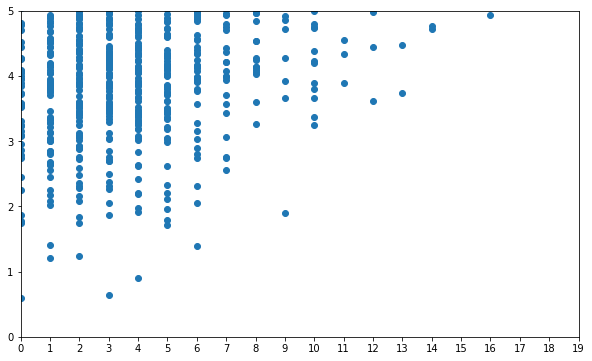

In [193]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_train, lr.predict(X_train))
plt.xlim(0,5)
plt.ylim(0,5)
plt.xticks(range(0,20));

In [181]:
y_train.describe()

count    783.000000
mean       4.577267
std        3.290511
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       20.000000
Name: R, dtype: float64

In [188]:
preds = lr.predict(X_train)
pd.Series(preds).describe()

count    783.000000
mean       4.577267
std        1.317801
min        0.592127
25%        3.710036
50%        4.529145
75%        5.469469
max        8.904258
dtype: float64

## Modeling Win/Loss

In [194]:
drop_cols = ['Rk', 'Date', 'Tm_x', 'Opp', 'Rslt', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'R',
            'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'WPA',
            'RE24', 'aLI', 'LOB', '#', 'Attendance', 'GmLen', 'Game#', 'Tm_y',
            'Player', 'Tm']

In [195]:
model_df = master.drop(drop_cols, axis=1)

In [196]:
X = model_df.drop('Win/Loss', axis=1)
y = model_df['Win/Loss']

- Note: I want Home/Away and ADI/weather info

## tb: Team Batting
- PA: Plate Appearances
- AB: At Bats
- R: Runs
- H: Hits
- BB: Bases on Balls
- IBB: Intentional Bases on Balls 
- SO: Strikeouts
- HBP: Hit-by-pitch
- SH: Sacrifice Hits
- SF: Sacrifice Flies
- ROE: Reached on Error
- GDB: Double Plays Grounded Into
- SB: Stolen Bases
- CS: Caught Stealing
- WPA: Win Probability Added for Offensive Player (BR measure)
- RE24: Base-out Runs Added (BR measure)
- aLI: Average Leverage Index (BR measure)
- LOB: Runners Left on Base
- #: Number of Players Used in Game
- GmLen: Game Length (minutes)

## tp: Team Pitching
- ER: Earned Runs Allowed
- UER: Unearned Runs Allowed
- Pit: Number of total pitches
- Str: Number of total strikes
- IR: Number of inherited runners
- IS: Inherited Score
- BF: Batters Faced
- SB: Stolen Bases
- CS: Caught Stealing
- PO: Pickoffs
- BK: Balks
- ERA: Earned Run Average
- WPA: Win Probability added by Pitcher (BR measure)
- RE24: Base-Out Runs Saved (BR measure)
- #: Number of pitchers used in the game

## pp: Player Pitching
- AppDec: Indicates starting and ending of pitcher
- GSc: Game Score (BR Measure)
- WP: Wild Pitches